In [4]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score

In [5]:
import pandas as pd 
def load_train_data():
    data = pd.read_csv('Acoustic_train.csv')
    return data

def load_test_data():
    data = pd.read_csv('Acoustic_test_no_class.csv')
    return data

train_data = load_train_data()
test_data = load_test_data()

In [6]:
# Preprocessing: Feature scaling and selection
scaler = StandardScaler()
feature_selector = SelectKBest(score_func=f_classif, k=20)

In [7]:
# Define individual models with basic hyperparameters
nb_classifier = GaussianNB()
rf_classifier = RandomForestClassifier(random_state=42)
logreg_classifier = LogisticRegression(max_iter=500, random_state=42)


In [8]:
# Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[
        ('naive_bayes', nb_classifier),
        ('random_forest', rf_classifier),
        ('logistic_regression', logreg_classifier)
    ],
    voting='soft'
)

In [9]:
# Pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('feature_selection', feature_selector),
    ('voting_classifier', voting_classifier)
])

In [10]:
# Define parameter grid for Random Forest and Logistic Regression
param_grid = {
    'voting_classifier__random_forest__n_estimators': [50, 100, 200],
    'voting_classifier__random_forest__max_depth': [10, 20, None],
    'voting_classifier__logistic_regression__C': [0.1, 1, 10],
}

In [11]:
# Split data
X_train = train_data.drop(columns=["Index", "Class"])
y_train = train_data["Class"]
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
# GridSearchCV to optimize hyperparameters
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_split, y_train_split)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection', SelectKBest(k=20)),
                                       ('voting_classifier',
                                        VotingClassifier(estimators=[('naive_bayes',
                                                                      GaussianNB()),
                                                                     ('random_forest',
                                                                      RandomForestClassifier(random_state=42)),
                                                                     ('logistic_regression',
                                                                      LogisticRegression(max_iter=500,
                                                                                         random_state=42))],
                                                         voting='soft'))]),
             n_jobs=-1,
             param_grid={'voting_classifier__logistic_regression__C': [0.1, 1,
                                                                       10],
                         'voting_classifier__random_forest__max_depth': [10, 20,
                                                                         None],
                         'voting_classifier__random_forest__n_estimators': [50,
                                                                            100,
                                                                            200]},
             scoring='accuracy')

In [13]:
# Best model evaluation
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

print("Best Parameters:", grid_search.best_params_)
print("Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Accuracy:", accuracy_score(y_val, y_val_pred))


Best Parameters: {'voting_classifier__logistic_regression__C': 10, 'voting_classifier__random_forest__max_depth': 10, 'voting_classifier__random_forest__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

       angry       0.73      0.92      0.81        12
       happy       0.93      0.93      0.93        14
       relax       0.81      0.65      0.72        20
         sad       0.67      0.71      0.69        14

    accuracy                           0.78        60
   macro avg       0.79      0.80      0.79        60
weighted avg       0.79      0.78      0.78        60

Accuracy: 0.7833333333333333


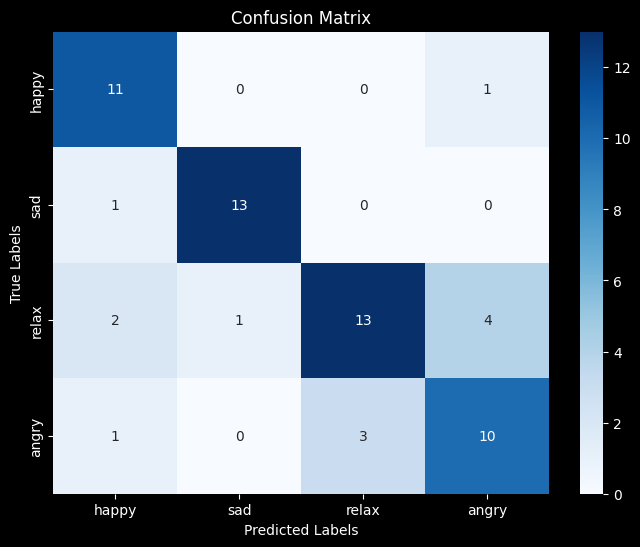

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_labels, title="Confusion Matrix"):
    """
    Plots a confusion matrix using seaborn heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, class_labels=['happy', 'sad', 'relax', 'angry'])


In [15]:
# Drop the 'Index' column from test data
X_test = test_data.drop(columns=["Index"])

# Predict the class for the test data
y_test_pred = best_model.predict(X_test)

# Add the predicted class to the test data
test_data['Predicted_Class'] = y_test_pred

# Display the test data with the predicted class
print(test_data[['Index', 'Predicted_Class']])

    Index Predicted_Class
0       1             sad
1       2             sad
2       3           relax
3       4           relax
4       5           relax
..    ...             ...
95     96           angry
96     97           angry
97     98           angry
98     99           happy
99    100           relax

[100 rows x 2 columns]
